In [1]:
import base64
import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings

warnings.simplefilter(action = 'ignore', category = FutureWarning)

# Preprocessing Functions

In [3]:
def decode_base64(item):
    return base64.b64decode(item.encode()).decode('utf-8')

In [4]:
def decode_human_ai_hash(df):
    df = df.drop(columns=[col for col in df.columns if 'Unnamed' in col])
    df = df.applymap(lambda x: x.replace('\xa0', '').strip() if isinstance(x, str) else x)
    df['hash'] = df['hash'].apply(decode_base64)
    df['REQID_ex'] = df['hash'].str.split('__________').str[0]
    df['author'] = df['hash'].str.split('__________').str[-1]
    df.drop(columns = ['hash'], inplace = True)

    nan_summary = df.isnull().sum()
    print("Number of NaN values in each column:\n", nan_summary)
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            majority_value = df[column].mode()[0]
            df[column].fillna(majority_value, inplace = True)
    return df

In [5]:
participants = ['p1', 'p2', 'p3', 'p4']

human_assessed_requirements = [pd.read_excel(f'./{i}_human_evaluation/tasks_b_and_c/task_c.xlsx') for i in participants]
human_assessed_requirements = [decode_human_ai_hash(df) for df in human_assessed_requirements]

Number of NaN values in each column:
 requirement                                                                                                        0
Based on the style and content of the requirement, do you believe it was written by a human or generated by AI?    0
This requirement is well-structured according to the ISO-29248 recommended syntax.                                 0
The use of signaling keywords to indicate the presence of a requirement is appropriate based on ISO-29148.         0
REQID_ex                                                                                                           0
author                                                                                                             0
dtype: int64
Number of NaN values in each column:
 requirement                                                                                                        0
Based on the style and content of the requirement, do you believe it was written by a human 

In [6]:
likert_label2id = {
    'Strongly Disagree': 1,
    'Disagree': 2,
    'Neutral': 3,
    'Agree': 4,
    'Strongly Agree': 5
}

ai_human_label2id = {
    'AI': 0,
    'HUMAN': 1
}

likert_id2label = {v: k for k, v in zip(likert_label2id.keys(), likert_label2id.values())}
ai_human_id2label = {v: k for k, v in zip(ai_human_label2id.keys(), ai_human_label2id.values())}

In [7]:
human_assessed_requirements_concated = pd.concat(human_assessed_requirements, axis = 0)
human_ai, syntax_quality, keyword_quality = human_assessed_requirements_concated.columns[1:-2]

In [8]:
# # mapping labels to id mapping
human_assessed_requirements_concated[human_ai] = human_assessed_requirements_concated[human_ai].map(ai_human_label2id)
human_assessed_requirements_concated['author'] = human_assessed_requirements_concated['author'].map(ai_human_label2id)
human_assessed_requirements_concated[syntax_quality] = human_assessed_requirements_concated[syntax_quality].map(likert_label2id)
human_assessed_requirements_concated[keyword_quality] = human_assessed_requirements_concated[keyword_quality].map(likert_label2id)
human_assessed_requirements_concated

,requirement,"Based on the style and content of the requirement, do you believe it was written by a human or generated by AI?",This requirement is well-structured according to the ISO-29248 recommended syntax.,The use of signaling keywords to indicate the presence of a requirement is appropriate based on ISO-29148.,REQID_ex,author
0,The program shall respond to start of transcei...,1,4,5,56111,0
1,The system shall provide the ability to manage...,0,2,2,2607,1
2,Visual and acoustic warnings to the driver abo...,1,2,4,43101,1
3,The product shall generate a Comparative Marke...,0,5,5,PROMISE-2,1
4,"""Due to non-disclosure agreements, this requir...",1,5,5,66922,1
...,...,...,...,...,...,...
63,If ifr Conditions change by 500ft or reset tim...,0,1,1,43101,0
64,80% of end users should have the capability to...,0,5,5,PROMISE-6,1
65,The product shall be available 99% of the time...,0,2,2,PROMISE-1,0
66,"""Due to non-disclosure agreements, this requir...",1,5,5,55892,1


# Descriptive Statistics (not shown on the paper)

In [9]:
# Ploting Likert percentage frequencies 
import plot_likert

def prepare_data_for_likert_precentage_scale_plot(df, likert_columns, filter_distro):
    select_ai = filter_distro[0]
    select_hu = filter_distro[1]
    syntax_quality = likert_columns[0]
    keyword_quality = likert_columns[1]

    # Filter HUMAN
    q1_hu_authored_syntax = df[df['author'] == ai_human_label2id[select_hu]][syntax_quality]
    q2_hu_authored_skeyword = df[df['author'] == ai_human_label2id[select_hu]][keyword_quality]
    
    # Filter AI
    q1_ai_authored_syntax = df[df['author'] == ai_human_label2id[select_ai]][syntax_quality]
    q2_ai_authored_skeyword = df[df['author'] == ai_human_label2id[select_ai]][keyword_quality]

    hu_ai_syntax = {
        'Human': [likert_id2label[i] for i in q1_hu_authored_syntax],
        'ReqBrain': [likert_id2label[i] for i in q1_ai_authored_syntax]
    }
    hu_ai_keyword = {
        'Human': [likert_id2label[i] for i in q2_hu_authored_skeyword],
        'ReqBrain': [likert_id2label[i] for i in q2_ai_authored_skeyword]
        }
    hu_ai_syntax_df = pd.DataFrame(hu_ai_syntax)
    hu_ai_keyword_df = pd.DataFrame(hu_ai_keyword)
    
    return hu_ai_syntax_df, hu_ai_keyword_df

In [10]:
human_ai_q1, human_ai_q2 = prepare_data_for_likert_precentage_scale_plot(human_assessed_requirements_concated,
                                                                         likert_columns = [syntax_quality, keyword_quality],
                                                                         filter_distro = ['AI', 'HUMAN'])

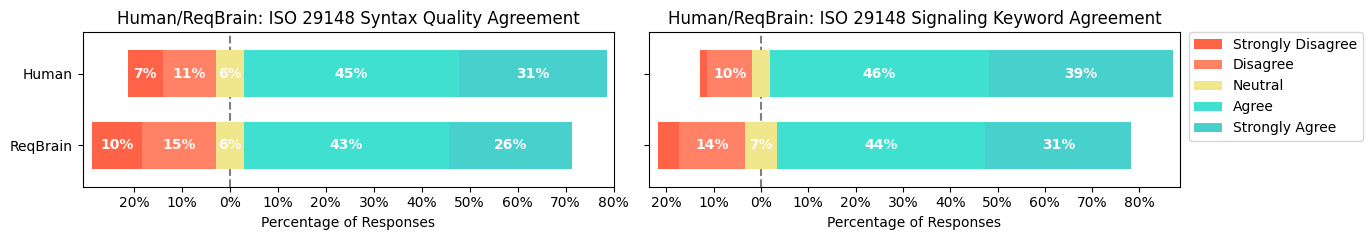

In [11]:
plot_likert.__internal__.BAR_LABEL_FORMAT = "%.0f"

scale = likert_label2id.keys()
my_color_scheme = [
    plot_likert.colors.TRANSPARENT,
    '#FF6347',  # Tomato (strong disagreement)
    '#FF8266',  # Lighter tomato
    '#F0E68C',  # Khaki (neutral color matching both)
    '#40E0D0',  # Turquoise
    '#48D1CC'   # Medium Turquoise (strong agreement)
]

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 2.5))
ax1.set_title("Human/ReqBrain: ISO 29148 Syntax Quality Agreement")
plot_likert.plot_likert(human_ai_q1, scale, plot_percentage = True,
                        bar_labels = True, 
                        bar_labels_color = "snow", 
                        colors = my_color_scheme,
                        ax = ax1,
                        legend = 0,
                        width = 0.65)

ax2.set_title("Human/ReqBrain: ISO 29148 Signaling Keyword Agreement")
plot_likert.plot_likert(human_ai_q2, scale, plot_percentage = True, 
                        bar_labels = True, 
                        bar_labels_color="snow", 
                        colors = my_color_scheme,
                        ax = ax2,
                        legend = 0,
                        width = 0.65)

ax2.set_yticklabels([])
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor = (1.1456, .88))
plt.tight_layout()
plt.savefig('./raw_human_rating_plots_not/task_c_raw_ratings.png', dpi = 300)
plt.show()

## **Variable Name:** Perceived Authorship$_{(PA)}$  
**Variable Description:** Based on the style and content of the requirement, do you believe it was written by a human or generated by AI?

---

## **Hypotheses:**

- **H$_{0,2}$:** Humans do not reliably distinguish between human-authored and ReqBrain-generated requirements in terms of accuracy.

- **H$_{a,2}$:** Humans reliably distinguish between human-authored and ReqBrain-generated requirements.

---
## **Report:** 
The results indicates no statistically significant difference in identification accuracy failing to reject the null hypothesis with an observed χ²(1, N = 544) = 0.015, p = .903. Further, human precision in distinguishing human-authored from ReqBrain-authored requirements was 50.7%.

# Code

In [12]:
labels = ai_human_label2id.keys()
y_true = human_assessed_requirements_concated['author']
y_pred = human_assessed_requirements_concated[human_ai]
raw_ratings = np.array([human_assessed_requirements[p].loc[:, human_ai].to_numpy() for p in range(len(participants))], dtype = 'object').T

In [13]:
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters

def fleiss_kappa_ci(raw_ratings, confidence = 0.95, n_resamples = 2000, seed = 42):
    kappa_samples = []
    n_items = raw_ratings.shape[0]
    
    rng = np.random.RandomState(seed)    
    for i in range(n_resamples):
        indices = rng.choice(n_items, size = n_items, replace = True)
        bootstrap_sample = counts[indices]
        
        # check if valid
        n_ratings_per_item = bootstrap_sample.sum(axis=1)
        if np.all(n_ratings_per_item == n_ratings_per_item[0]):
            try:
                kappa_val = fleiss_kappa(bootstrap_sample)
                kappa_samples.append(kappa_val)
            except (AssertionError, ValueError):
                continue  
    if len(kappa_samples) < 100:  # Need sufficient valid samples
        print(f"Warning: Only {len(kappa_samples)} valid bootstrap samples")
        return float(kappa_original), (np.nan, np.nan), cats
    
    # calculate CI
    alpha = (1 - confidence) / 2
    lower = np.percentile(kappa_samples, alpha * 100)
    upper = np.percentile(kappa_samples, (1 - alpha) * 100)
    
    return (float(lower), float(upper))

In [14]:
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from scipy.stats import chi2_contingency, chi2
from scipy.stats.contingency import odds_ratio

counts, cats = aggregate_raters(raw_ratings)
fleiss_statistics = fleiss_kappa(counts)
kappa_low, kapp_high = fleiss_kappa_ci(raw_ratings)
print("Categories:", list(cats))
print(f"Fleiss' Kappa: {fleiss_statistics:.4f} | 95% CI: [{kappa_low:.4f}, {kapp_high:.4f}]\n")


print('sample size:')
print(f'n1: {int(len(y_true)/2)}')
print(f'n2: {int(len(y_pred)/2)}\n')

confusion_matrix = confusion_matrix(y_true, y_pred)
chi2_stat, p_value_0, dof, expected = chi2_contingency(confusion_matrix)
print(f"P-Value: {p_value_0}")
print(f"Degrees of freedom: {dof}")
print(f"Chi-Square Test Statistic: {chi2_stat}")
print(f"Contingency Frequencies:\n {confusion_matrix}")
print(f"Expected Frequencies:\n {expected}")

confidence = 0.95
odds_r = odds_ratio(confusion_matrix)
print(f"\nOdds_ratio: {odds_r.statistic}")
odds_ci_low = odds_r.confidence_interval(confidence_level = confidence).low
odds_ci_high = odds_r.confidence_interval(confidence_level = confidence).high
print(f"{int(confidence * 100)}% Confidence Interval for Vargha and Delaney's A: ({odds_ci_low:.5f}, {odds_ci_high:.5f})\n")

precision = precision_score(y_true, y_pred)
print(f"\nHuman precision in differentiating human vs. ReqBrain-authored requirements: {precision:.3f}")

n = len(y_true)
z_score = stats.norm.ppf(1 - (1 - confidence) / 2)
margin_of_error = z_score * np.sqrt((precision * (1 - precision)) / n)
confidence_interval = (precision - margin_of_error, precision + margin_of_error)
print(f"{confidence * 100}% Confidence Human precision in differentiating human vs. ReqBrain-authored requirements: {confidence_interval}")

Categories: ['AI', 'HUMAN']
Fleiss' Kappa: 0.0654 | 95% CI: [-0.0375, 0.1705]

sample size:
n1: 136
n2: 136

P-Value: 0.9033123088324688
Degrees of freedom: 1
Chi-Square Test Statistic: 0.014756944444444444
Contingency Frequencies:
 [[65 71]
 [63 73]]
Expected Frequencies:
 [[64. 72.]
 [64. 72.]]

Odds_ratio: 1.0605790649147424
95% Confidence Interval for Vargha and Delaney's A: (0.64078, 1.75630)


Human precision in differentiating human vs. ReqBrain-authored requirements: 0.507
95.0% Confidence Human precision in differentiating human vs. ReqBrain-authored requirements: (0.447530039574786, 0.5663588493141029)


# **Why Mann-Whitney U-test and Vargha and Delaney’s A?**
The non-parametric Mann-Whitney U-test was selected due to the potential for non-normal data distributions and the presence of outliers, which are common in software engineering experiments involving randomized algorithms [1]. Additionally, Vargha and Delaney’s A was chosen as the effect size measure, as it provides a robust, non-parametric assessment of stochastic superiority between groups, making it well-suited for data that may not adhere to normality [2].

### **References:**
[1] A. Arcuri and L. Briand, "A Practical Guide for Using Statistical Tests to Assess Randomized Algorithms in Software Engineering," in Proceedings of the 33rd International Conference on Software Engineering (ICSE'11), Honolulu, HI, USA, 2011, pp. 1-10.<br>

[2] N. L. Leech and A. J. Onwuegbuzie, "A Call for Greater Use of Nonparametric Statistics," presented at the Annual Meeting of the Mid-South Educational Research Association, Chattanooga, TN, USA, Nov. 2002.

---

## **Vargha and Delaney’s A Resutls:**
- **Vargha and Delaney’s A**: 0.54

### **Vargha Interpretation Cheet Sheet:**
* A = 0.5 indicates no difference between the two groups (i.e., the distributions overlap completely).
* A > 0.5 suggests that the first group tends to have larger values than the second group.
* A < 0.5 suggests that the second group tends to have larger values than the first group. <br>

The interpretation of Vargha and Delaney's A in terms of effect size is as follows:<br>

* 0.56 ≤ A < 0.64 (or 0.36 ≤ A < 0.44) suggests a small effect size.
* 0.64 ≤ A < 0.71 (or 0.29 ≤ A < 0.36) suggests a medium effect size.
* A ≥ 0.71 (or A ≤ 0.29) suggests a large effect size.

# Implementation

In [15]:
# Calculating basic statistics
def calculate_statistics(sample):
    n = len(sample)
    mean = np.mean(sample)
    median = np.median(sample)
    std_dev = np.std(sample, ddof = 1)

    print(f'n {n}')
    print(f'Mean {mean:.3f}')
    print(f'Median {median:.3f}')
    print(f'Standard Deviation {std_dev:.3f}')

In [16]:
# Calculating Vargha's Delany A effect szie
from scipy.stats import rankdata

def vargha_delaney_A(sample_1, sample_2):
    combined = np.concatenate([sample_1, sample_2])
    ranks = rankdata(combined)
    rank_sum_x = np.sum(ranks[:len(sample_1)])
    rank_sum_y = np.sum(ranks[len(sample_1):])
    A = (rank_sum_x / len(sample_1) - (len(sample_1) + 1) / 2) / len(sample_2)
    return A

In [17]:
# Calculating CI
def bootstrapped_ci(sample_1, sample_2, n_samples = 1000, method = 'basic', ci = .95):
    samples_1_2 = (sample_1, sample_2)
    resampled_medians = bootstrap(samples_1_2, vargha_delaney_A, n_resamples = 1000, method = 'basic', confidence_level = ci, random_state = 42)
    ci_lower, ci_upper = resampled_medians.confidence_interval
    return ci, ci_lower, ci_upper

In [18]:
# Run all statistics
from scipy.stats import bootstrap
from scipy.stats import mannwhitneyu

def stats_report(sample_1, sample_2):
    print("Sample 1: Human Authored\n")
    calculate_statistics(sample_1)
    
    print('\n')
    print("Sample 2: ReqBrain Authored\n")
    calculate_statistics(sample_2)

    print('\n')
    u_stat, p_value = mannwhitneyu(sample_1, sample_2)
    print(f"p_value: {p_value:.5f}")
    print("Mann-Whiteny U Statistics:", u_stat)

    print('\n')
    A = vargha_delaney_A(sample_1, sample_2)
    print(f"Vargha and Delaney’s A: {A:.3f}")
    ci, ci_lower, ci_upper = bootstrapped_ci(sample_1, sample_2)
    print(f"{int(ci * 100)}% Confidence Interval for Vargha and Delaney's A: ({ci_lower:.5f}, {ci_upper:.5f})")
    return p_value

## **Variable Name:** Written Syntax Compliance$_{(WSC)}$ 
**Variable Description:** This requirement is well-structured according to the ISO-29248 recommended syntax.

---

## **Hypotheses:**
- **$H_{0,5}$:** Human-authored and ReqBrain-generated requirements do not differ in their adherence to ISO 29148 written syntax.
- **$H_{a,5}$:** Human-authored and ReqBrain-generated requirements differ in their adherence to ISO 29148 written syntax.

---

## **Report:** 
The results indicated no significant difference, failing to find support to reject the null hypothesis with $U = 10118.5$ and $p = .155$. 
Comparing descriptive statistics for both groups are as follows: compared between human-authored requirements $(n = 136; M = 3.81; Median = 4; SD = 1.20)$ and ReqBrain-generated requirements $(n = 136; M = 3.58; Median = 4; SD = 1.30)$.

# Code

In [19]:
# Separate if the requirement was AI-generated or human-written
ai_ratings_iso = human_assessed_requirements_concated[human_assessed_requirements_concated['author'] == ai_human_label2id['AI']][syntax_quality]
human_ratings_iso = human_assessed_requirements_concated[human_assessed_requirements_concated['author'] == ai_human_label2id['HUMAN']][syntax_quality]

p_value_1 = stats_report(human_ratings_iso, ai_ratings_iso)

Sample 1: Human Authored

n 136
Mean 3.809
Median 4.000
Standard Deviation 1.202


Sample 2: ReqBrain Authored

n 136
Mean 3.581
Median 4.000
Standard Deviation 1.303


p_value: 0.15521
Mann-Whiteny U Statistics: 10118.5


Vargha and Delaney’s A: 0.547
95% Confidence Interval for Vargha and Delaney's A: (0.48115, 0.61320)


## **Variable Name:** Signaling Keywords Compliance$_{(SKC)}$  
**Variable Description:** The use of signaling keywords to indicate the presence of a requirement is appropriate based on ISO-29148.

---

## **Hypotheses:**

- **$H_{0,6}$:** Human-authored and ReqBrain-generated requirements do not differ in their adherence to ISO 29148 signaling keywords.

- **$H_{a,6}$:** Human-authored and ReqBrain-generated requirements differ in their adherence to ISO 29148 signaling keywords.

---

## **Report:** 
The results indicated a difference between both groups, finding support for the alternative hypothesis with $U = 10482.0, p = .041$. However, the adjusted p-value using Holm-Bonferroni correction method  is $=0.12204$ contridicting the un-adjusted p-value indicating fail to reject the null hypothesis (see the last cell output).

Comparing the descriptive statistics is furhter confirming the adjusted p-value in favour of the null hypothesis: human-authored requirements $(n = 136; M = 4.12; Median = 4; SD = 0.97)$ and ReqBrain-generated requirements $(n = 136; M = 3.83; Median = 4; SD = 1.15)$.

# Code

In [20]:
ai_ratings_keyword = human_assessed_requirements_concated[human_assessed_requirements_concated['author'] == ai_human_label2id['AI']][keyword_quality]
human_ratings_keyword = human_assessed_requirements_concated[human_assessed_requirements_concated['author'] == ai_human_label2id['HUMAN']][keyword_quality]
p_value_2 = stats_report(human_ratings_keyword, ai_ratings_keyword)

Sample 1: Human Authored

n 136
Mean 4.118
Median 4.000
Standard Deviation 0.967


Sample 2: ReqBrain Authored

n 136
Mean 3.831
Median 4.000
Standard Deviation 1.145


p_value: 0.04068
Mann-Whiteny U Statistics: 10482.0


Vargha and Delaney’s A: 0.567
95% Confidence Interval for Vargha and Delaney's A: (0.50734, 0.63080)


# Multiple Testing

## **Report:** 
All the addjusted p-values using Holm-Bonferroni correction method is confirming the un-adjusted p-values, except the last one (`p_value_2`).

In [21]:
from statsmodels.stats.multitest import multipletests

# Example list of p-values
pvals = [p_value_0, p_value_1, p_value_2]

# Perform Holm-Bonferroni correction
reject, pvals_corrected, _, _ = multipletests(pvals, alpha = 0.05, method = 'holm')

print("Original p-values:", [f"{i:.5f}" for i in pvals])
print("Adjusted p-values:", [f"{i:.5f}" for i in pvals_corrected])
print("Reject null hypothesis:", reject)

Original p-values: ['0.90331', '0.15521', '0.04068']
Adjusted p-values: ['0.90331', '0.31043', '0.12204']
Reject null hypothesis: [False False False]
